In [ ]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Chapter 12 병든 잎사귀 식별

- 평가지표: ROC AUC
- 옵티마이져: AdamW


In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


시각화를 이용해 타깃값 분포 확인하기

In [ ]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

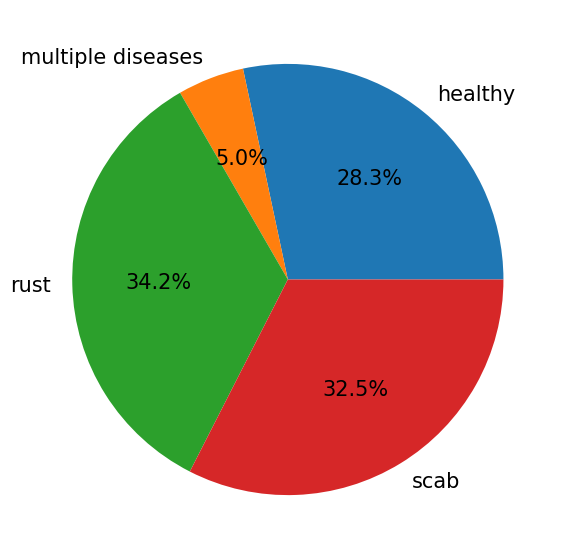

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels=label,
        autopct='%.1f%%');

In [ ]:
import torch # 파이토치
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(train,
                                test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=50)

데이터셋 클래스 정의

In [ ]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)              # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:
            return image # 테스트용일 때
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label # 훈련/검증용일 때

이미지 변환기 정의

In [ ]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환
    A.Normalize(),            # 정규화 변환
    ToTensorV2()              # 텐서로 변환
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: This augmenter is very slow. Try to use ``ElasticTransform`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


In [ ]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

데이터셋 및 데이터 로더 생성

In [ ]:
img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [ ]:
dataset_train

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [ ]:
!pip install efficientnet-pytorch==0.7.1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=9259d1e344f6b088b89bde5d253843b92a6fd61f458fc3217

In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [ ]:
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)

model = model.to(device) # 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:03<00:00, 71.8MB/s]


Loaded pretrained weights for efficientnet-b7


In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

훈련 및 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)

    # '반복 횟수'만큼 반복
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item()
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')

    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()

            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-16-018a2192bf0d>", line 22, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



예측 및 결과 제출

In [ ]:
dataset_test = ImageDataset(test, img_dir=img_dir,
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

예측

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-16-018a2192bf0d>", line 22, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [ ]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission.csv', index=False)